Stable Diffusion is a latent, text-to-image diffusion model that was released in 2022. Latent diffusion models (LDMs) operate by repeatedly reducing noise in a latent representation space and then converting that representation into a complete image.

A model that combines different neural networks, the process of text-to-image generation in Stable Diffusion can be divided into four. Here’s an overview:



*   First, an Image Encoder converts training images into vectors in a mathematical space known as the latent space, where image information can be represented as arrays of numbers and have lower dimensions compared to the original input.
*   A Text Encoder translates text into high-dimensional vectors that machine learning models can comprehend.
*   A Diffusion Model then utilizes the text guidance to create new images in the latent space.
*   Finally, an Image Decoder transforms the image data from the latent space into an actual image constructed with pixels.

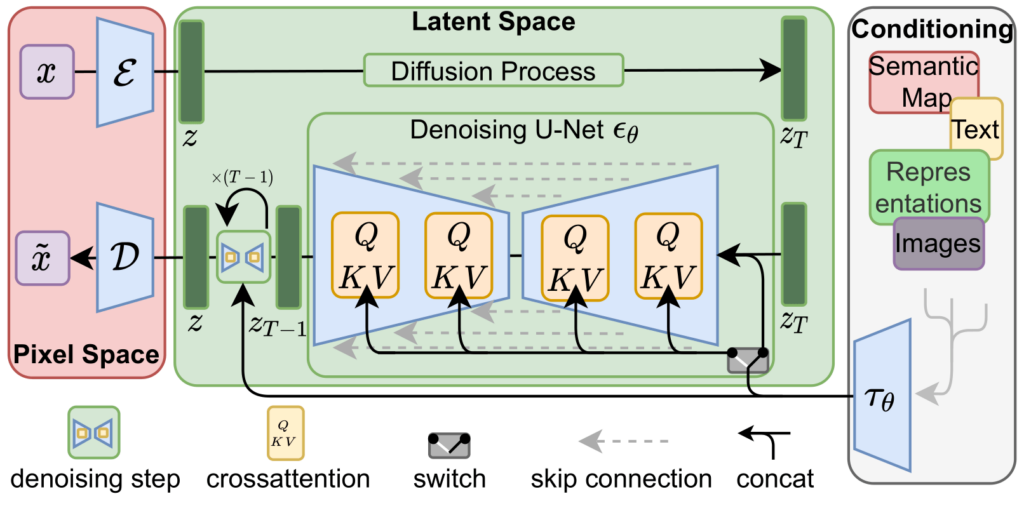

The primary function of Stable Diffusion is to generate detailed images based on text descriptions, but it can also be used for other tasks like inpainting, outpainting, and creating image-to-image translations guided by text prompts. Its weights, model card, and code are available publicly.

# Stable Diffusion Initialisation

In [ ]:
!pip install transformers diffusers lpips accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 19.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms


# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Variational Autoencoder (VAE)

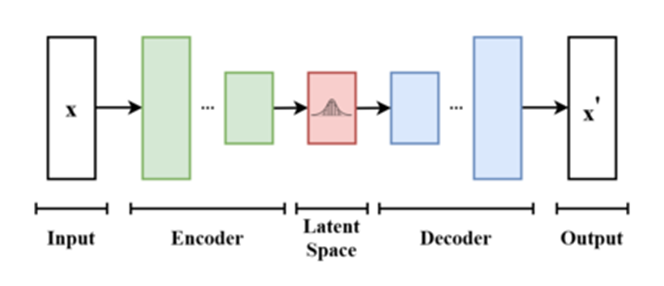

In machine learning, dimensionality reduction is the process of reducing the number of features that describe some data. This reduction is done either by selection (only some existing features are conserved) or by extraction (a reduced number of new features are created based on the old features) and can be useful in many situations that require low dimensional data (data visualization, data storage, heavy computation…).
The encoder is responsible for representing the input in a lower dimension (Latent Space). The Decoder is responsible for taking back the data to its original dimension. Normal autoencoder tries to push data points as far from each other as possible. Because of this, random samples from latent space don’t create valid images and you cannot create new images from the data.
To be able to use the decoder of our autoencoder for generative purposes, we must be sure that the latent space is regular enough. One possible solution to obtain such regularity is to introduce explicit regularization during the training process. Thus, a variational autoencoder can be defined as being an autoencoder whose training is regularized to avoid overfitting and ensure that the latent space has good properties that enable generative process.


To introduce some regularization of the latent space, we proceed to a slight modification of the encoding-decoding process: instead of encoding an input as a single point, we encode it as a distribution over the latent space. The model is then trained as follows:
*   first, the input is encoded as distribution over the latent space
*   second, a point from the latent space is sampled from that distribution
*   third, the sampled point is decoded, and the reconstruction error can be computed
*   finally, the reconstruction error is backpropagated through the network



The loss function that is minimized when training a VAE is composed of a “reconstruction term” (on the final layer), that tends to make the encoding-decoding scheme as performant as possible, and a “regularization term” (on the latent layer), that tends to regularize the organization of the latent space by making the distributions returned by the encoder close to a standard normal distribution. That regularization term is expressed as the Kulback-Leibler divergence between the returned distribution and a standard Gaussian.

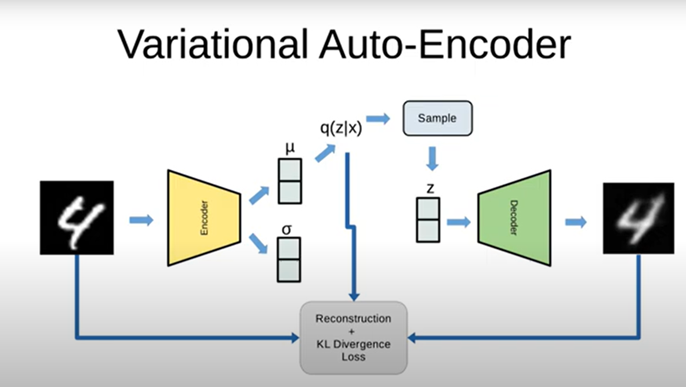

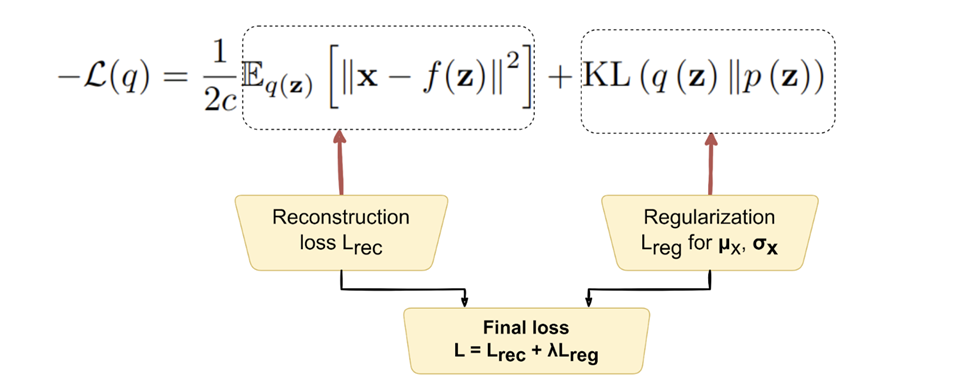

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

# CLIP

CLIP is a pre-trained model for telling you how well a given image and a given text caption fit together, introduced by the paper “Learning Transferrable Visual Models from Natural Language Supervision” (2021) from OpenAI. It was trained contrastively on a huge amount (400 million) of web scraped data of image-caption pairs.

During training, the model requires that a huge batch of image-text pairs is fed at once (e.g., 20,000 pairs). That way, each batch contains 20,000*20,000 = 400,000,000 possible pairs, with only 20,000 being correct pairs. For efficient processing, the similarity scores of all possible pairs are computed at once to yield a 20,000 by 20,000 matrix, with the values in the diagonal being the similarity scores for the correct image-text pairs. That way, the objective function can have the goal to maximize the scores in the diagonal and minimize all the scores not in the diagonal.


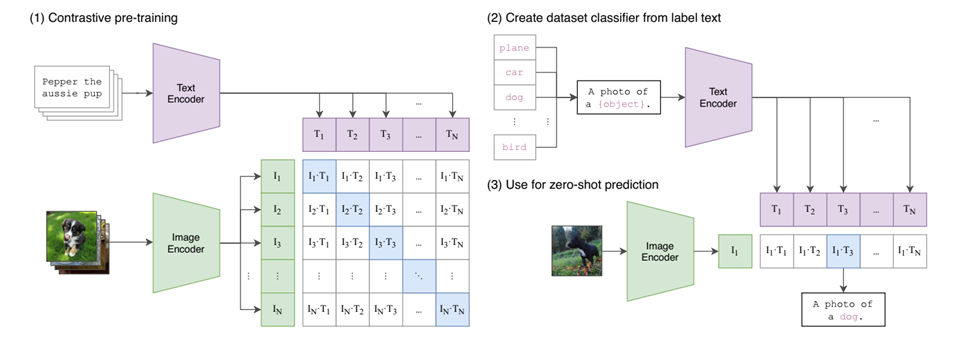

In [ ]:
# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

# Diffusion Model

Denoising Diffusion Probabilistic Model paper was introduced at the end of 2020 (https://arxiv.org/abs/2006.11239).

What distinguishes diffusion models from other types of latent variable models is that the approximate posterior q(x1:T |x0), called the forward process or diffusion process, is fixed to a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule β1, . . . , βT.

Basically, in a diffusion model, the goal is to add noise in fixed steps to destroy the original distribution (input image) to reach a gaussian distribution.

If we could start with a sample from the gaussian distribution and remove the noise from it, we could reconstruct the image. In order to achieve this, we train a model to learn to remove a small amount of noise in each step.



The training and sampling steps can be explained as fallows:

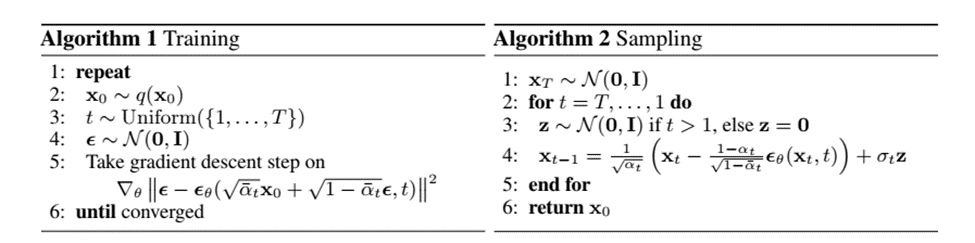

A crucial aspect of image generation is conditioning the sampling process to manipulate the generated samples. To turn a diffusion model 𝑝𝜃 into a conditional diffusion model, we can add conditioning information 𝑦 at each diffusion step.

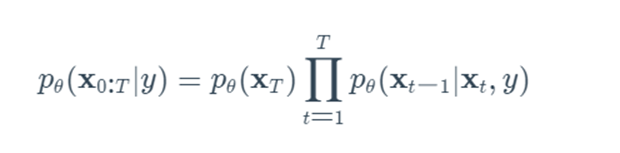

Sohl-Dickstein et al. and later Dhariwal and Nichol showed that we can use a second model, a classifier, to guide the diffusion toward the target class during training. To achieve that, we can train a classifier on the noisy image to predict its class. Then we can use the gradients to guide the diffusion.

In the famous GLIDE paper by Nichol et al, the authors expanded on this idea and use CLIP embeddings to guide the diffusion. CLIP as proposed by Saharia et al., consists of an image encoder 𝑔 and a text encoder ℎ. It produces an image and text embeddings 𝑔(𝑥𝑡) and ℎ(𝑐), respectively, wherein 𝑐 is the text caption.

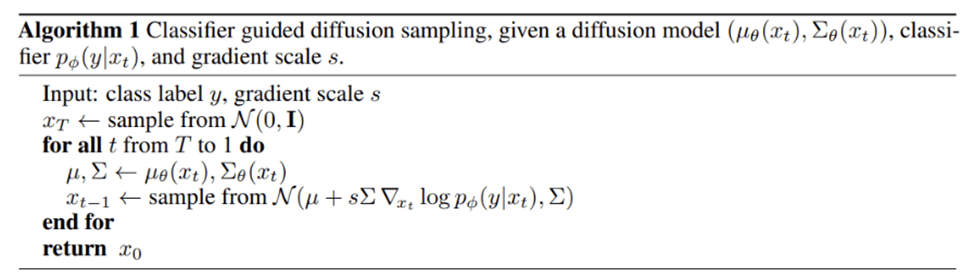


Guidance can be achieved without a second classifier model as proposed by Ho & Salimans. Instead of training a separate classifier, the authors trained a conditional diffusion model 𝜖𝜃(𝑥𝑡∣𝑦) together with an unconditional model 𝜖𝜃(𝑥𝑡∣0)ϵ. In fact, they use the exact same neural network. During training, they randomly set the class 𝑦 to 0, so that the model is exposed to both the conditional and unconditional setup.

# Unet

As shown earlier, the developers of Stable Diffusion used a UNET architecture to create the model. U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg.

In the original Unet, the layers are consist of convolutional layers with skip connections and either downsampling or upsampling, depending on which side of the network you are. But in Stable diffusion, the authors have included transformers and attention blocks as well.

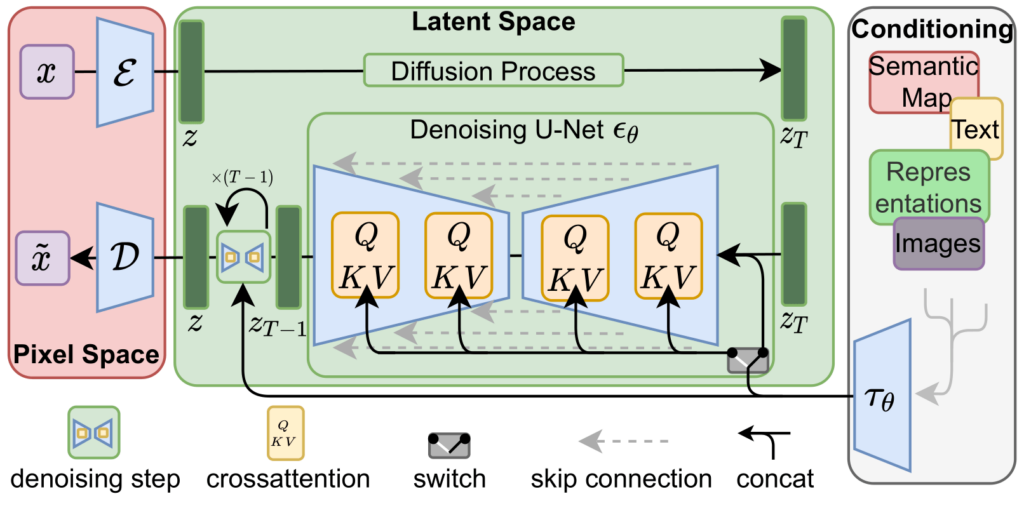

In [ ]:
# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

# The Scheduler

A scheduler takes a model’s output (the sample which the diffusion process is iterating on) and a timestep to return a denoised sample. The timestep is important because it dictates where in the diffusion process the step is; data is generated by iterating forward n timesteps and inference occurs by propagating backward through the timesteps. Based on the timestep, a scheduler may be discrete in which case the timestep is an int or continuous in which case the timestep is a float.

Depending on the context, a scheduler defines how to iteratively add noise to an image or how to update a sample based on a model’s output:


*   during training, a scheduler adds noise (there are different algorithms for how to add noise) to a sample to train a diffusion model
*   during inference, a scheduler defines how to update a sample based on a pretrained model’s output


LMSDiscreteScheduler is a linear multistep scheduler for discrete beta schedules.

In [ ]:
# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# Text to Image

In [ ]:
# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

# Extra explanation

In [ ]:
prompt = ["A dragon fighting an angle in a demonic wasteland"] # the prompt to condition the diffusion process
# we use the tokenizer from CLIP to tokenize the prompt
#input_ids: representation of each token in the dictionary
#attention_mask: telling the model which words are part of prompt and which are just padding and should be ignored
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [ ]:
text_input

{'input_ids': tensor([[49406,   320,  5471,  4652,   550,  6946,   530,   320, 46920, 44035,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [ ]:
# using the CLIP encoder to transform the prompt (after being tokenized) and get the embeddings

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))

In [ ]:
text_embeddings[0].shape

torch.Size([1, 77, 768])

In [ ]:
# CLIP accepts maximum of 77 tokens
max_length = text_input.input_ids.shape[-1]
max_length

77

In [ ]:
# the number of input channels for the UNET
unet.config.in_channels

4

In [ ]:
batch_size = 1
height = 512 # final image hight
width = 768 # Final image width
generator = torch.manual_seed(4) # random seed

# creating a random noisy image as a starting point
latents = torch.randn(
(batch_size, unet.config.in_channels, height // 8, width // 8),
generator=generator,
)
latents.shape

torch.Size([1, 4, 64, 96])

In [ ]:
scheduler.set_timesteps(50)
scheduler.sigmas[0]

tensor(14.6146)

In [ ]:
vae.config.scaling_factor

0.18215

# Stable Diffusion Pipeline for Text to Image generation

0it [00:00, ?it/s]

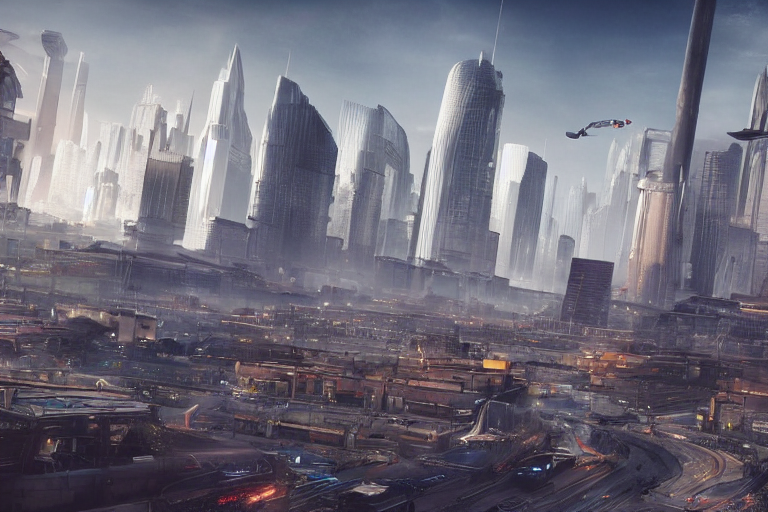

In [ ]:
prompt = ["A dystopian city with skylines and flying cars"]
height = 512 # image hight
width = 768 # image width
num_inference_steps = 50 # number of diffusion steps
guidance_scale = 7.5 # controls how much the guidance impacts the image generation
generator = torch.manual_seed(420) # random seed
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
(batch_size, unet.config.in_channels, height // 8, width // 8),
generator=generator,
)

latents = latents.to(torch_device)
# scale the initial noise by the standard deviation required by the scheduler
latents = latents * scheduler.sigmas[0]

    # Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]

        # In the case of LMSDesc scheduler:
        # Scales the denoising model input by `(sigma**2 + 1) ** 0.5` to match the K-LMS algorithm.
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
            # print(noise_pred.shape)

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        # print(noise_pred_uncond.shape)
        # print(noise_pred_text.shape)

        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        # print(noise_pred.shape)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents)["prev_sample"]
        # print(t)

# scale and decode the image latents with vae
# We introduced the scale factor in the latent diffusion paper.
# The goal was to handle different latent spaces (from different autoencoders, which can be scaled quite differently than images)
# with similar noise schedules. The scale_factor
# ensures that the initial latent space on which the diffusion model is operating has approximately unit variance.
latents = latents / vae.config.scaling_factor

with torch.no_grad():
    image = vae.decode(latents)

# print(image['sample'].shape)
image = image['sample']
# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]